In [240]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('..')
from src import soporte_temporales as st
from src import soporte_sarima as ss

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [412]:
df_accidentes = pd.read_csv('..//Datos//datos_accidentes//datos_accidentes_seriet.csv')
df_defunciones = pd.read_csv('..//Datos//datos_defunciones//datos_defunciones_seriet.csv')
df_autos_historicos = pd.read_csv('..//Datos//datos_parquev//parquev_historico.csv')
df_poblacion = pd.read_csv('../Datos/Datos_poblacion.csv', index_col=0)

# Accidentes

In [242]:
df_accidentes.head()

,FECHA,Accidentes
0,2007-01-01,138
1,2007-02-01,125
2,2007-03-01,134
3,2007-04-01,130
4,2007-05-01,108


In [243]:
# instanciamos la clase
analisis_st = ss.TimeSeriesAnalysis(df_accidentes, temporal_column="FECHA", value_column="Accidentes")

analisis_st.exploracion_datos()

El número de filas es 204 y el número de columnas es 1

----------

En este conjunto de datos tenemos 126 valores duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Accidentes,204,139,22,71,125,138,151,195


In [244]:
analisis_st.comprobar_serie_continua()

La serie temporal es continua, no faltan meses.


In [245]:
analisis_st.graficar_serie()

In [246]:
analisis_st.graficar_media_movil(window=12)

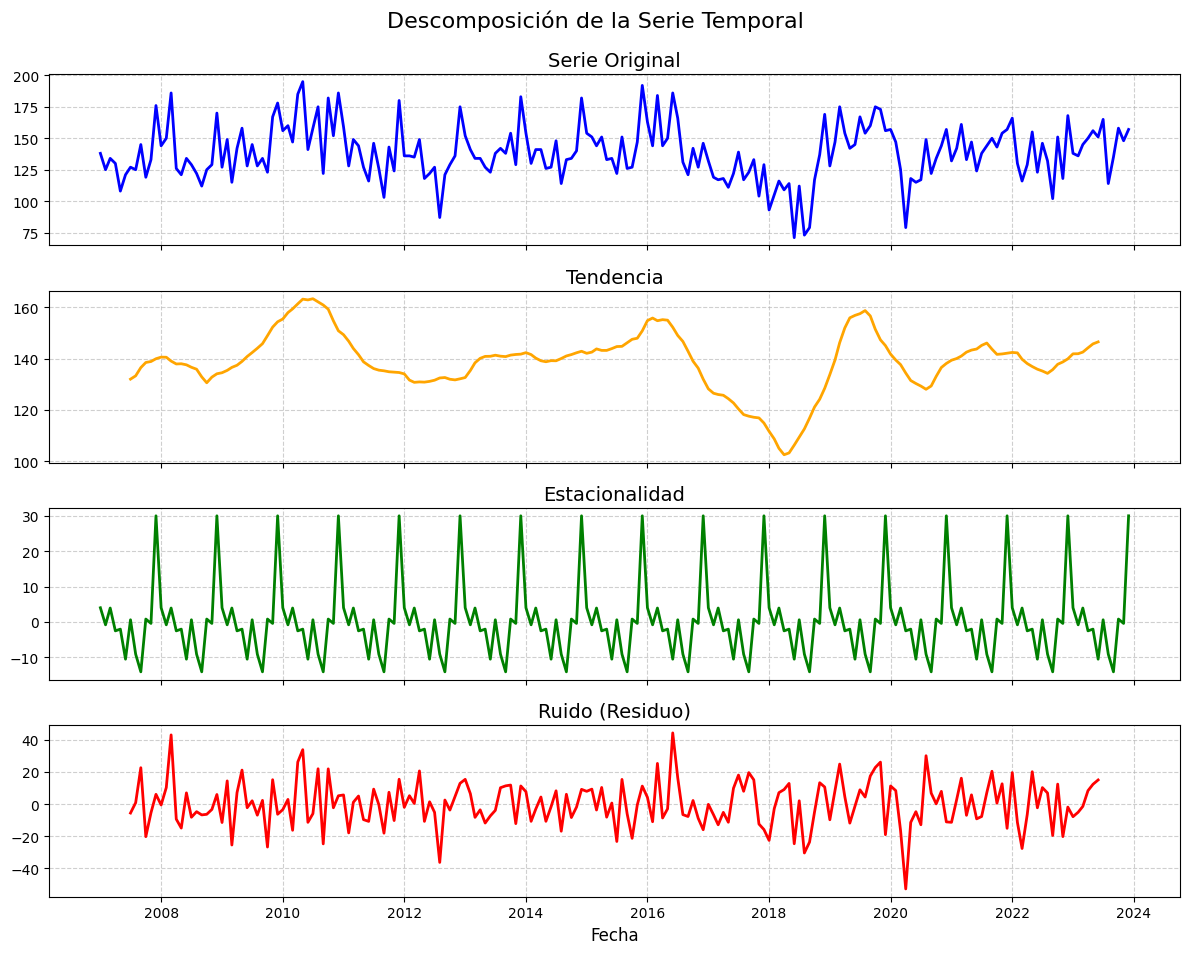

In [247]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

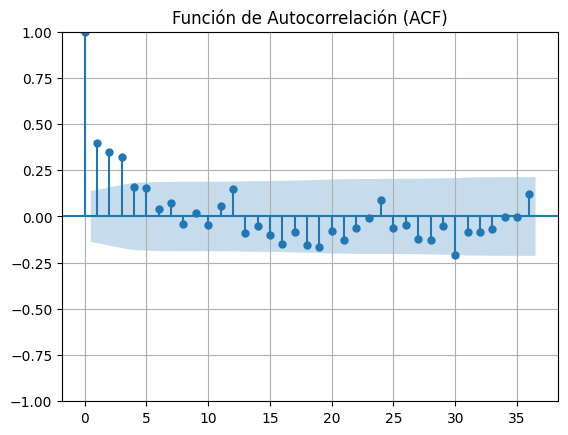

<Figure size 1200x1000 with 0 Axes>

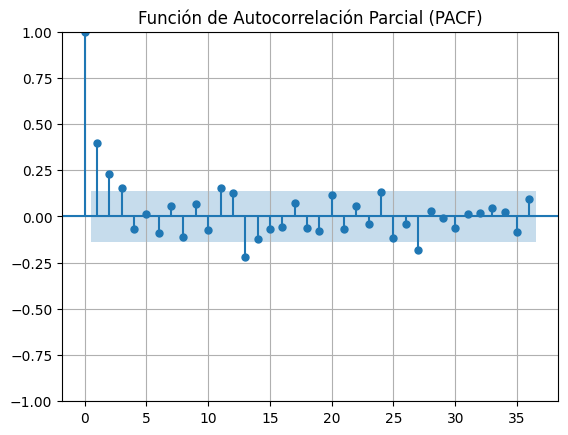

In [248]:
analisis_st.graficar_acf_pacf(lags=36)

In [249]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -3.6373384481895483
p-value: 0.00508603462364682
Valores Críticos:
1%: -3.4652439354133255
5%: -2.8768752281673717
10%: -2.574944653739612
Rechazamos la hipótesis nula. La serie es estacionaria.


Sarima

In [250]:
df_accidentes.set_index('FECHA', inplace=True)

In [251]:
df_accidentes.head()

,Accidentes
FECHA,
2007-01-01,138
2007-02-01,125
2007-03-01,134
2007-04-01,130
2007-05-01,108


In [252]:
train_size = int(0.7 * len(df_accidentes))
y_train, y_test = df_accidentes[:train_size], df_accidentes[train_size:]

In [253]:
sarima = ss.SARIMAModel()

# Definir los rangos para los parámetros
p_range = range(4)
q_range = range(5)
seasonal_order_ranges = (
    range(2),  # P
    range(2),  # D
    range(2),  # Q
    [12]       # S
)

# Generar parámetros
parametros = sarima.generar_parametros(p_range, q_range, seasonal_order_ranges)
parametros[:5] # Ver algunas combinaciones

[(0, 0, (0, 0, 0, 12)),
 (0, 0, (0, 0, 1, 12)),
 (0, 0, (0, 1, 0, 12)),
 (0, 0, (0, 1, 1, 12)),
 (0, 0, (1, 0, 0, 12))]

  0%|          | 0/160 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodel

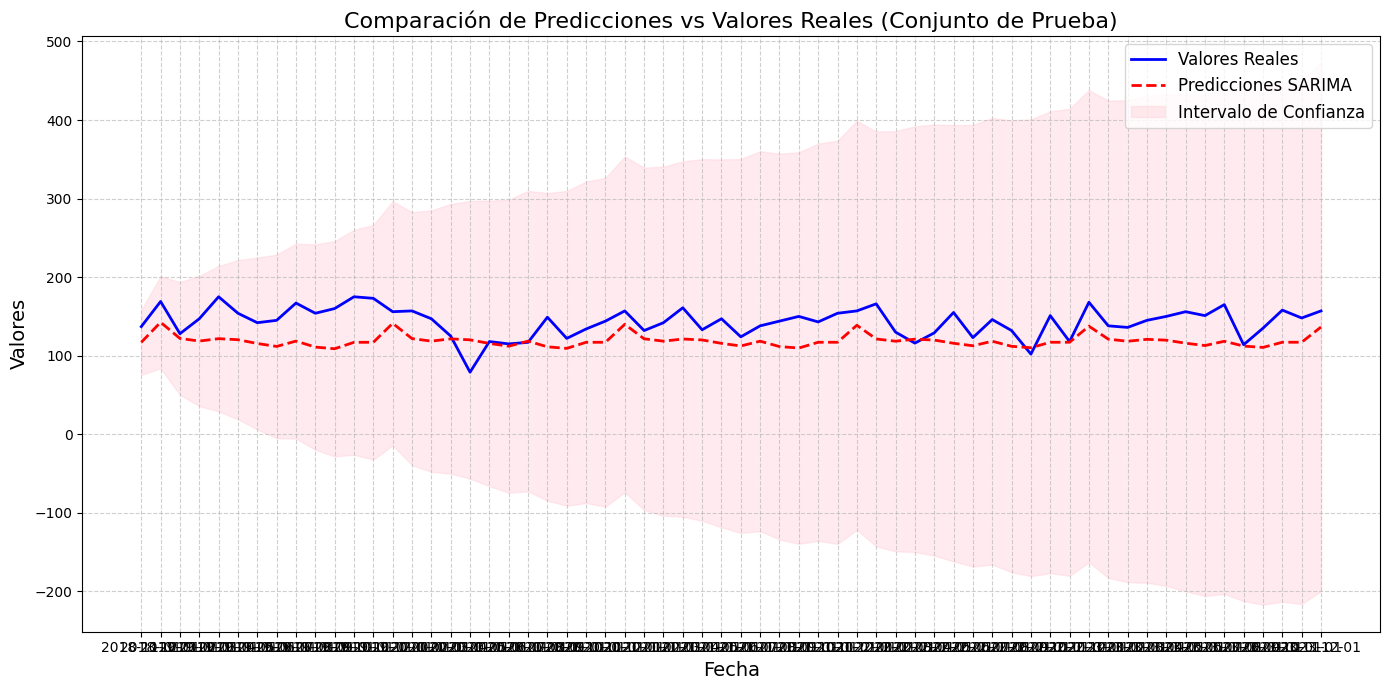

In [254]:
# Evaluar modelos
results_df = sarima.evaluar_modelos(y_train, y_test, parametros, diferenciacion=1, df_length=len(df_accidentes), variable="Accidentes")

In [255]:
# Ordenar resultados por RMSE
results_df = results_df.sort_values(by="RMSE", ascending=True)
results_df.head()

,p,q,seasonal_order,RMSE
5,0,0,"(1, 0, 1, 12)",30
0,0,0,"(0, 0, 0, 12)",32
7,0,0,"(1, 1, 1, 12)",33
3,0,0,"(0, 1, 1, 12)",34
1,0,0,"(0, 0, 1, 12)",35


In [256]:
modelo_sarima= SARIMAX(df_accidentes, 
                    order= (3,1,3),                    #Se pone la p, la d y la q
                    seasonal_order= (1,1,1,12)).fit()   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y= modelo_sarima.predict(start= len(df_accidentes), end=len(df_accidentes)+24)   #pongo el más 30 porque son los que quiero predecir

pred_y= pred_y.astype(int)
datos_predichos=pd.DataFrame(pred_y)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [257]:
y_test.index = pd.to_datetime(y_test.index)
datos_predichos.index = pd.to_datetime(datos_predichos.index)

Text(0.5, 1.0, 'Predicción a futuro de accidentes de vehículos en República Dominicana')

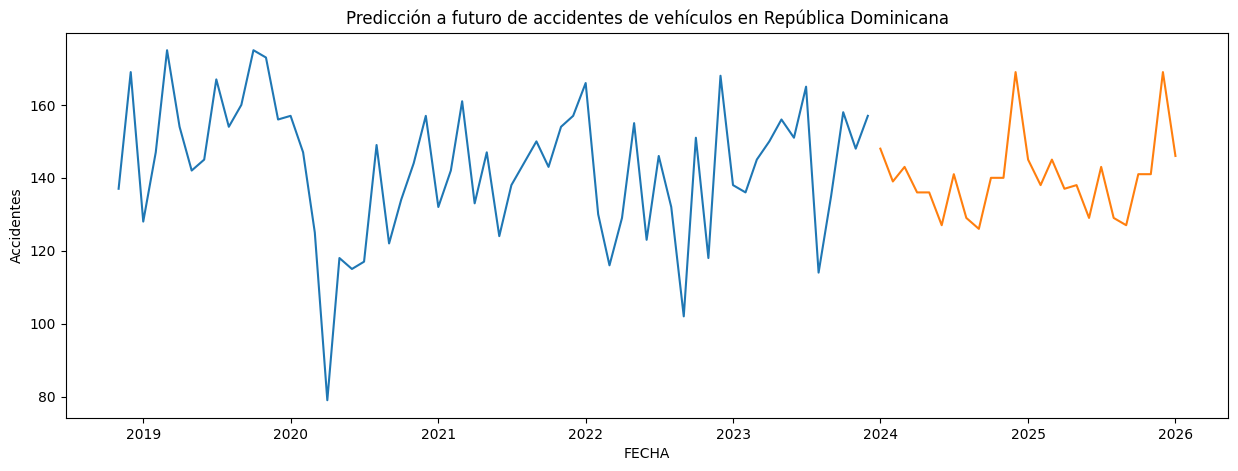

In [258]:
plt.figure(figsize=(15,5))

sns.lineplot(x=y_test.index, y='Accidentes', data=y_test)
sns.lineplot(x=datos_predichos.index, y='predicted_mean', data=datos_predichos)
plt.title('Predicción a futuro de accidentes de vehículos en República Dominicana')

# Defunciones

In [259]:
df_defunciones.head()

,FECHA,Defunciones
0,2007-01-01,146
1,2007-02-01,136
2,2007-03-01,156
3,2007-04-01,147
4,2007-05-01,117


In [260]:
df_copia = df_defunciones.copy()
df_copia['FECHA'] = pd.to_datetime(df_copia['FECHA'])
df_copia["Month"] = df_copia["FECHA"].dt.month_name()
df_copia["Year"] = df_copia["FECHA"].dt.year
df_copia.head()

,FECHA,Defunciones,Month,Year
0,2007-01-01,146,January,2007
1,2007-02-01,136,February,2007
2,2007-03-01,156,March,2007
3,2007-04-01,147,April,2007
4,2007-05-01,117,May,2007


In [261]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_copia, temporal_column="FECHA", value_column="Defunciones")

analisis_st.exploracion_datos()

El número de filas es 204 y el número de columnas es 3

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Defunciones,204,154,25,77,137,153,169,208
Year,204,2015,5,2007,2011,2015,2019,2023


In [262]:
analisis_st.comprobar_serie_continua()

La serie temporal es continua para la frecuencia 'M', no faltan periodos.


In [263]:
analisis_st.graficar_serie()

In [264]:
analisis_st.graficar_media_movil(window=12)

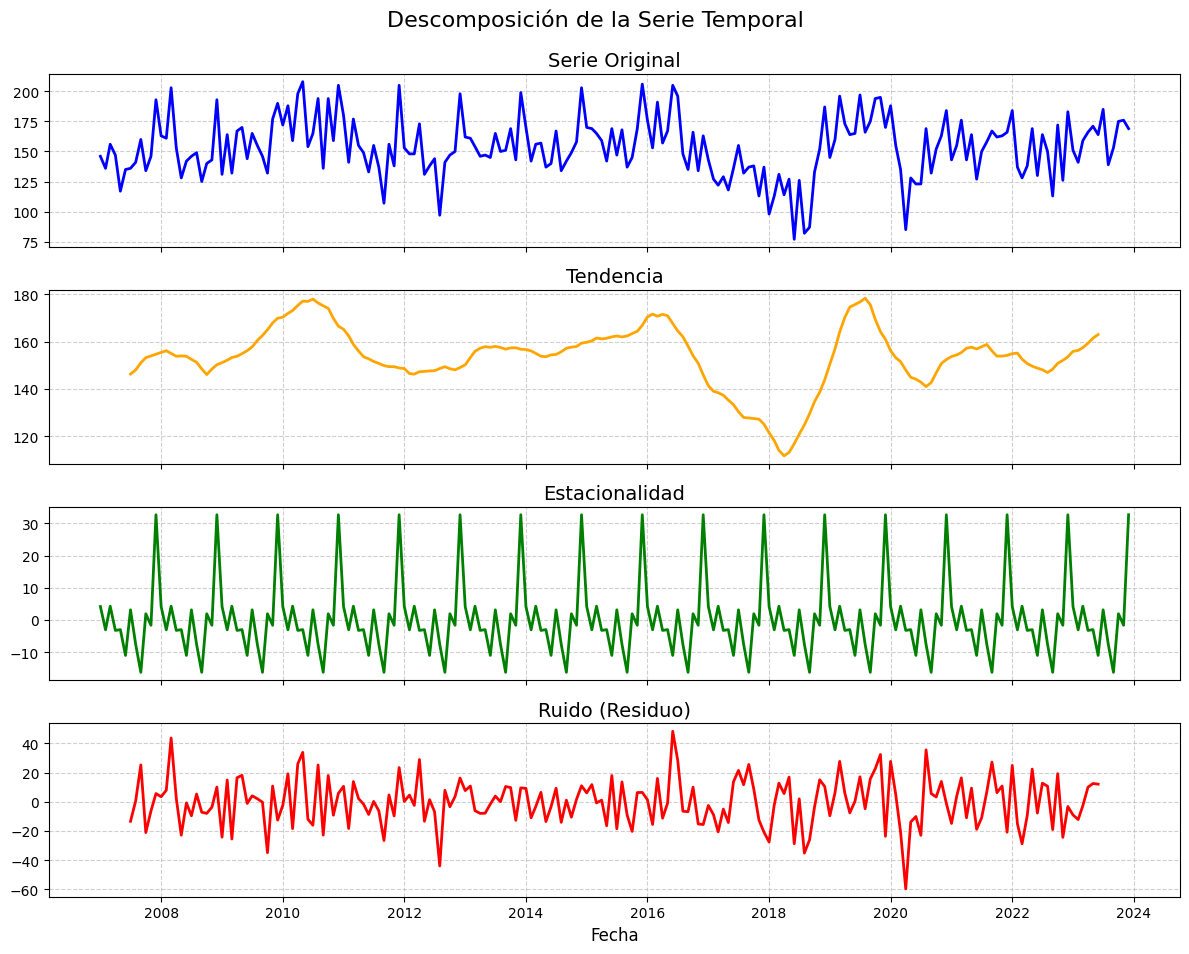

In [265]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

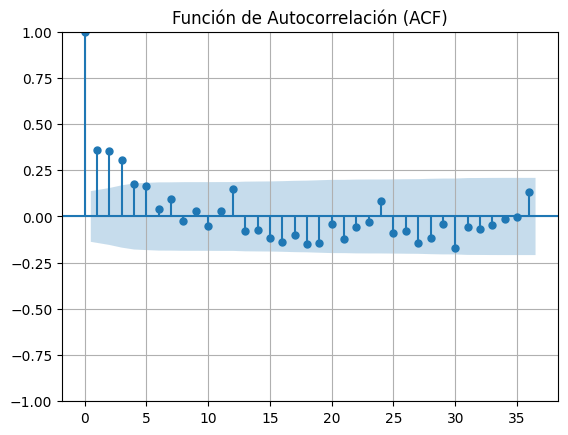

<Figure size 1200x1000 with 0 Axes>

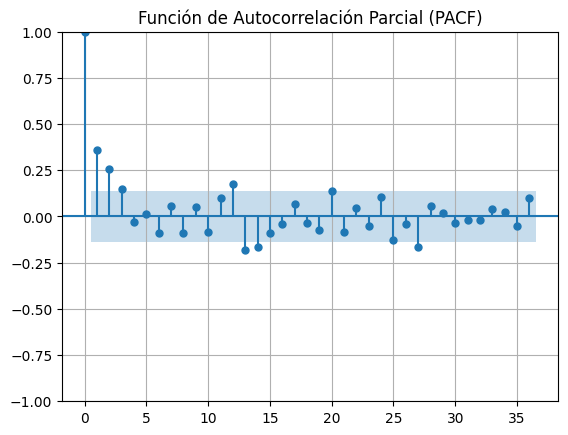

In [266]:
analisis_st.graficar_acf_pacf(lags=36)

In [267]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -3.6734269015355294
p-value: 0.004502839670564938
Valores Críticos:
1%: -3.4652439354133255
5%: -2.8768752281673717
10%: -2.574944653739612
Rechazamos la hipótesis nula. La serie es estacionaria.


In [268]:
df_defunciones.set_index('FECHA', inplace=True)

In [269]:
train_size = int(0.7 * len(df_defunciones))
y_train, y_test = df_defunciones[:train_size], df_defunciones[train_size:]

In [270]:
sarima = ss.SARIMAModel()

# Definir los rangos para los parámetros
p_range = range(4)
q_range = range(5)
seasonal_order_ranges = (
    range(2),  # P
    range(2),  # D
    range(2),  # Q
    [12]       # S
)

# Generar parámetros
parametros = sarima.generar_parametros(p_range, q_range, seasonal_order_ranges)
parametros[:5] # Ver algunas combinaciones

[(0, 0, (0, 0, 0, 12)),
 (0, 0, (0, 0, 1, 12)),
 (0, 0, (0, 1, 0, 12)),
 (0, 0, (0, 1, 1, 12)),
 (0, 0, (1, 0, 0, 12))]

  0%|          | 0/160 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodel

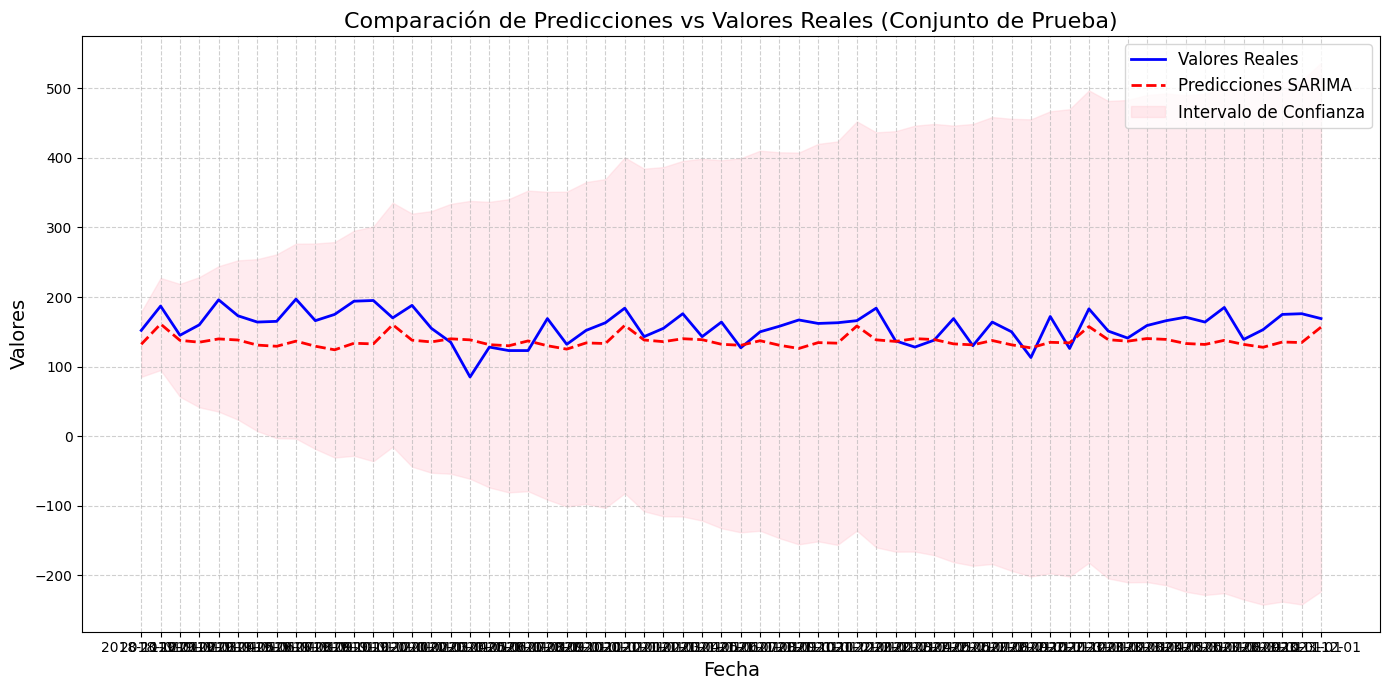

In [271]:
results_df = sarima.evaluar_modelos(y_train, y_test, parametros, diferenciacion=1, df_length=len(df_defunciones), variable="Defunciones")

In [272]:
# Ordenar resultados por RMSE
results_df = results_df.sort_values(by="RMSE", ascending=True)
results_df.head()

,p,q,seasonal_order,RMSE
5,0,0,"(1, 0, 1, 12)",30
0,0,0,"(0, 0, 0, 12)",33
7,0,0,"(1, 1, 1, 12)",34
3,0,0,"(0, 1, 1, 12)",34
1,0,0,"(0, 0, 1, 12)",34


In [273]:
modelo_sarima= SARIMAX(df_defunciones, 
                    order= (3,1,3),                    #Se pone la p, la d y la q
                    seasonal_order= (1,1,1,12)).fit()   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y= modelo_sarima.predict(start= len(df_defunciones), end=len(df_defunciones)+24)   #pongo el más 30 porque son los que quiero predecir

pred_y= pred_y.astype(int)
datos_predichos=pd.DataFrame(pred_y)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sari

In [274]:
y_test.index = pd.to_datetime(y_test.index)
datos_predichos.index = pd.to_datetime(datos_predichos.index)

Text(0.5, 1.0, 'Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

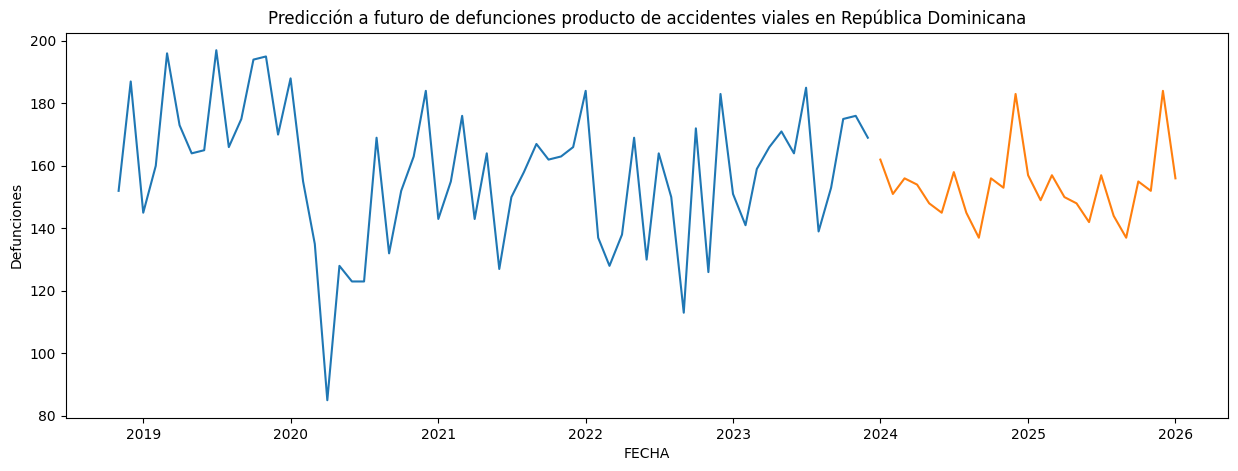

In [276]:
plt.figure(figsize=(15,5))

sns.lineplot(x=y_test.index, y='Defunciones', data=y_test)
sns.lineplot(x=datos_predichos.index, y='predicted_mean', data=datos_predichos)
plt.title('Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

In [364]:
df_defunciones.drop(columns='index', inplace=True)

In [ ]:
df_defunciones.reset_index(inplace=True)

### Modelo usando Prophet

In [365]:
df_defunciones.columns = ['ds', 'y']

In [366]:
df_defunciones.head()

,ds,y
0,2007-01-01,146
1,2007-02-01,136
2,2007-03-01,156
3,2007-04-01,147
4,2007-05-01,117


In [373]:
df_defunciones.tail()

,ds,y
199,2023-08-01,139
200,2023-09-01,153
201,2023-10-01,175
202,2023-11-01,176
203,2023-12-01,169


In [376]:
m = Prophet()
m.fit(df_defunciones)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=25, freq='M') 
m.predict(df_defunciones)

15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-01-01,156,130,188,156,156,4,4,4,4,4,4,0,0,0,159
1,2007-02-01,156,124,180,156,156,-4,-4,-4,-4,-4,-4,0,0,0,152
2,2007-03-01,155,130,187,155,155,4,4,4,4,4,4,0,0,0,160
3,2007-04-01,155,126,182,155,155,-2,-2,-2,-2,-2,-2,0,0,0,153
4,2007-05-01,155,125,179,155,155,-4,-4,-4,-4,-4,-4,0,0,0,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2023-08-01,152,114,170,152,152,-9,-9,-9,-9,-9,-9,0,0,0,143
200,2023-09-01,152,109,164,152,152,-16,-16,-16,-16,-16,-16,0,0,0,135
201,2023-10-01,151,127,186,151,151,3,3,3,3,3,3,0,0,0,155
202,2023-11-01,151,127,179,151,151,0,0,0,0,0,0,0,0,0,152


In [377]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
217,2025-01-31,147,118,175
218,2025-02-28,155,128,182
219,2025-03-31,150,122,178
220,2025-04-30,148,120,175
221,2025-05-31,139,110,167
222,2025-06-30,156,126,185
223,2025-07-31,142,112,170
224,2025-08-31,134,107,163
225,2025-09-30,154,127,183
226,2025-10-31,152,123,180


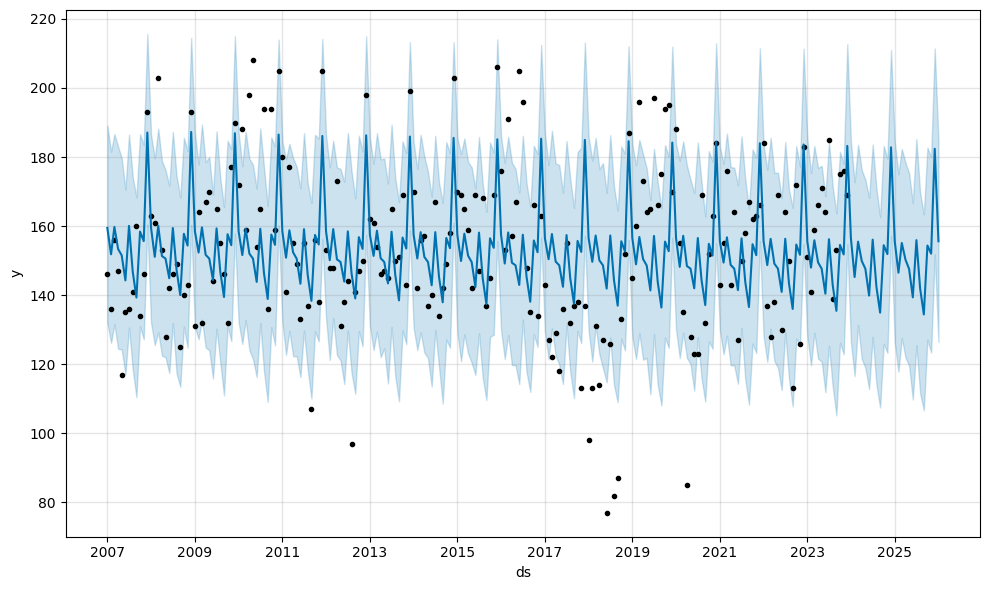

In [378]:
fig1 = m.plot(forecast)

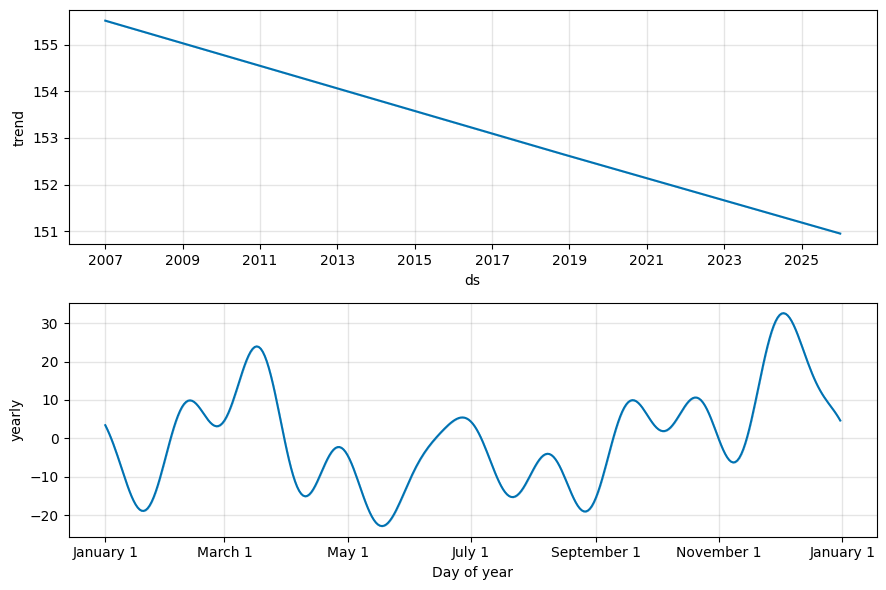

In [379]:
fig2 = m.plot_components(forecast)

In [380]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [381]:
plot_components_plotly(m, forecast)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



# Parque Vehicular

In [390]:
df_autos_historicos.head()

,Unnamed: 0,Total
0,1998,936083
1,1999,1090833
2,2000,1294998
3,2001,1436165
4,2002,1611023


In [391]:
df_autos_historicos.columns = ['FECHA', 'Vehículos']
df_autos_historicos['FECHA'] = pd.to_datetime(df_autos_historicos['FECHA'].astype(str) + '-12-31')

In [392]:
df_autos_historicos.head()

,FECHA,Vehículos
0,1998-12-31,936083
1,1999-12-31,1090833
2,2000-12-31,1294998
3,2001-12-31,1436165
4,2002-12-31,1611023


In [393]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_autos_historicos, temporal_column="FECHA", value_column="Vehículos")

analisis_st.exploracion_datos()

El número de filas es 27 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Vehículos,27,3118597,1526266,936083,1823660,2917573,4224111,6160988


In [394]:
analisis_st.comprobar_serie_continua(freq='A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [395]:
analisis_st.graficar_serie()

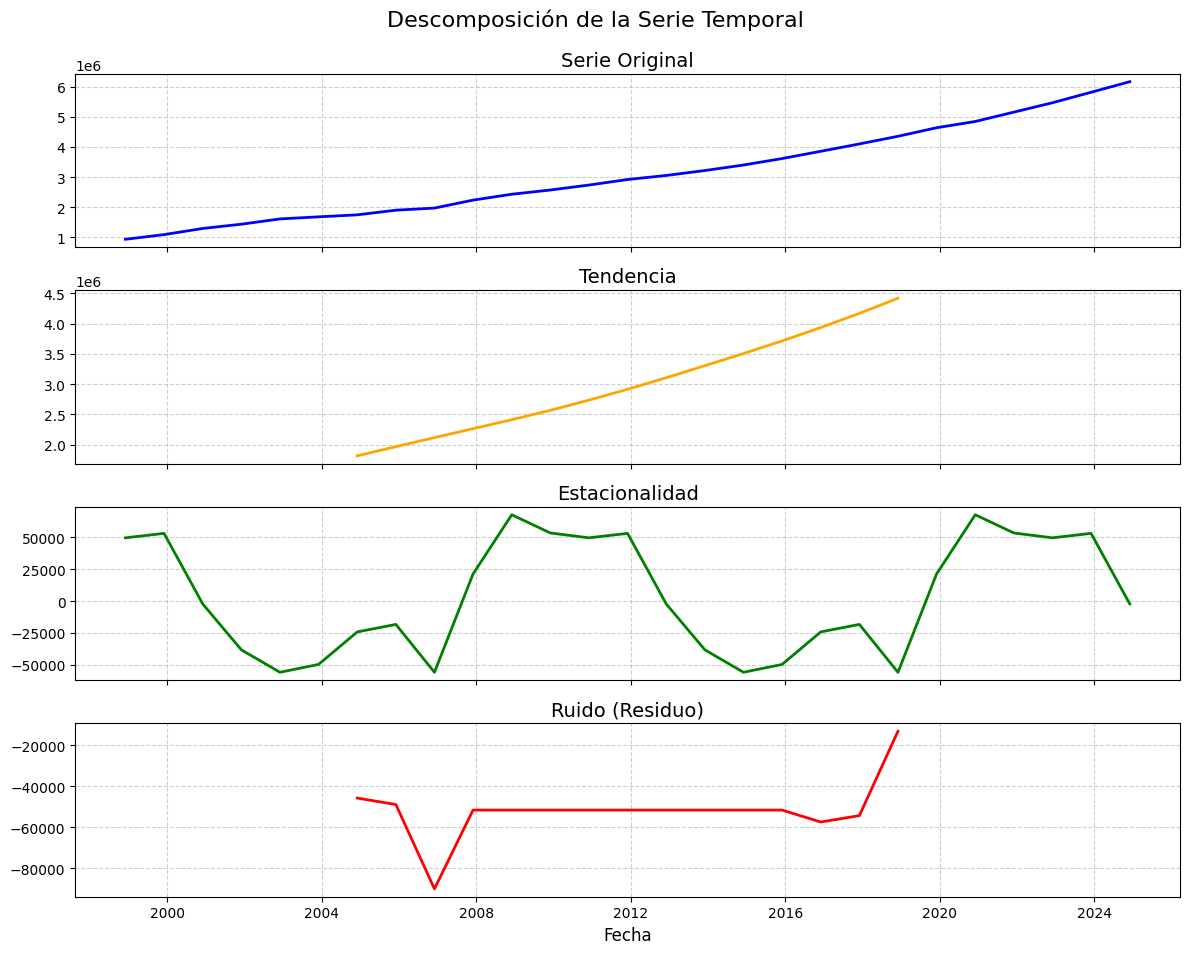

In [304]:
analisis_st.detectar_estacionalidad()

In [305]:
analisis_st.prueba_estacionariedad()

ADF Statistic: 6.443519495590372
p-value: 1.0
Valores Críticos:
1%: -3.7112123008648155
5%: -2.981246804733728
10%: -2.6300945562130176
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


ARIMA

In [306]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [307]:
train_size= int(0.7 * len(df_autos_historicos))
df_autos_historicos.set_index('FECHA', inplace=True)
df_autos_historicos.index = pd.to_datetime(df_autos_historicos.index)
# df_autos_historicos = df_autos_historicos.asfreq('A')

y_train, y_test = df_autos_historicos[:train_size], df_autos_historicos[train_size:]

In [309]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)
resultados_arima.head(3)

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages

,p,q,RMSE
0,1,1,632687
1,1,2,633129
2,1,3,637013


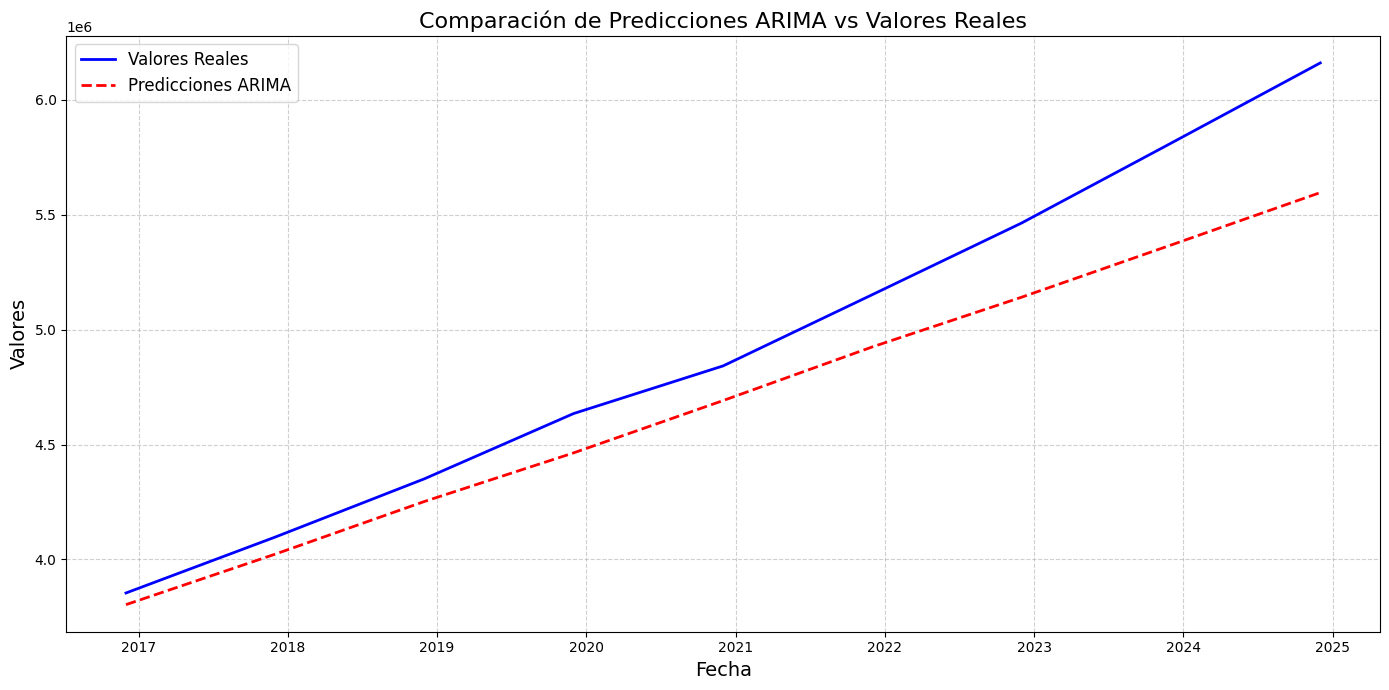

In [310]:
modelo_arima.visualizar_predicciones(y_test)

In [401]:
df_autos_historicos.head()

,index,FECHA,Vehículos
0,0,1998-12-31,936083
1,1,1999-12-31,1090833
2,2,2000-12-31,1294998
3,3,2001-12-31,1436165
4,4,2002-12-31,1611023


In [402]:
df_autos_historicos.drop(columns='index', inplace=True)

In [403]:
# df_autos_historicos.reset_index(inplace=True)
df_autos_historicos.columns = ['ds', 'y']

In [404]:
df_autos_historicos.head()

,ds,y
0,1998-12-31,936083
1,1999-12-31,1090833
2,2000-12-31,1294998
3,2001-12-31,1436165
4,2002-12-31,1611023


In [405]:
df_autos_historicos.tail()

,ds,y
22,2020-12-31,4842367
23,2021-12-31,5152448
24,2022-12-31,5463996
25,2023-12-31,5810888
26,2024-12-31,6160988


In [406]:
m = Prophet()
m.fit(df_autos_historicos)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=2, freq='Y') 
m.predict(future)

15:27:20 - cmdstanpy - INFO - Chain [1] start processing
15:27:21 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1998-12-31,662029,913177,1003548,662029,662029,297142,297142,297142,297142,297142,297142,0,0,0,959171
1,1999-12-31,811432,1080470,1169230,811432,811432,312234,312234,312234,312234,312234,312234,0,0,0,1123665
2,2000-12-31,961244,1224140,1308809,961244,961244,305977,305977,305977,305977,305977,305977,0,0,0,1267220
3,2001-12-31,1110558,1355934,1447193,1110558,1110558,295056,295056,295056,295056,295056,295056,0,0,0,1405614
4,2002-12-31,1237511,1490231,1582229,1237511,1237511,297142,297142,297142,297142,297142,297142,0,0,0,1534653
5,2003-12-31,1364241,1633277,1721179,1364241,1364241,312234,312234,312234,312234,312234,312234,0,0,0,1676475
6,2004-12-31,1491318,1748339,1842817,1491318,1491318,305977,305977,305977,305977,305977,305977,0,0,0,1797295
7,2005-12-31,1618048,1866869,1958821,1618048,1618048,295056,295056,295056,295056,295056,295056,0,0,0,1913104
8,2006-12-31,1744804,1993656,2084768,1744804,1744804,297142,297142,297142,297142,297142,297142,0,0,0,2041946
9,2007-12-31,1914753,2180608,2277397,1914753,1914753,312234,312234,312234,312234,312234,312234,0,0,0,2226987


In [407]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
24,2022-12-31,5491881,5447679,5535005
25,2023-12-31,5800888,5761330,5844881
26,2024-12-31,6089352,6044870,6135770
27,2025-12-31,6372347,6324976,6416731
28,2026-12-31,6668348,6615187,6720140


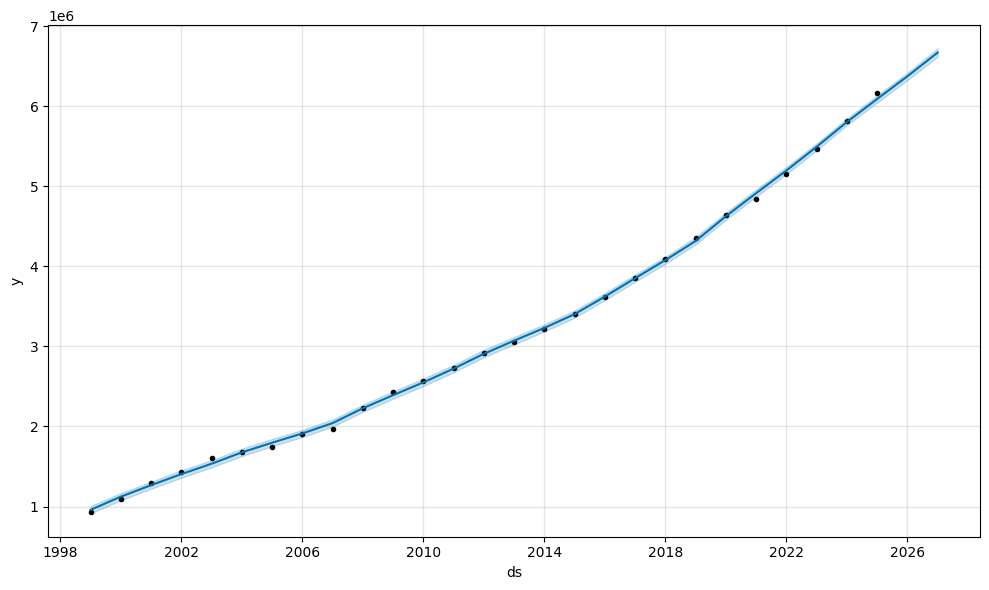

In [408]:
fig1 = m.plot(forecast)

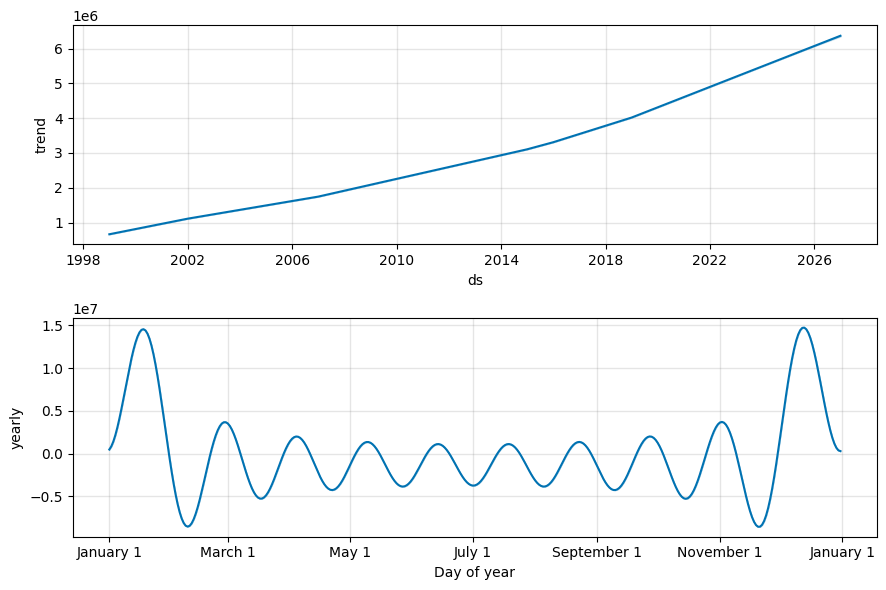

In [409]:
fig2 = m.plot_components(forecast)

In [410]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [411]:
plot_components_plotly(m, forecast)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



# Población

In [413]:
df_poblacion.head()

,ANOOCU,Población
0,1960,3298021
1,1961,3408415
2,1962,3521164
3,1963,3635798
4,1964,3752313


In [414]:
df_poblacion.columns = ['FECHA', 'Población']
df_poblacion['FECHA'] = pd.to_datetime(df_poblacion['FECHA'].astype(str) + '-12-31')

In [415]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_poblacion, temporal_column="FECHA", value_column="Población")

analisis_st.exploracion_datos()

El número de filas es 64 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Población,64,7329602,2443551,3298021,5203102,7352871,9432392,11332972


In [416]:
analisis_st.comprobar_serie_continua('A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [417]:
analisis_st.graficar_serie()

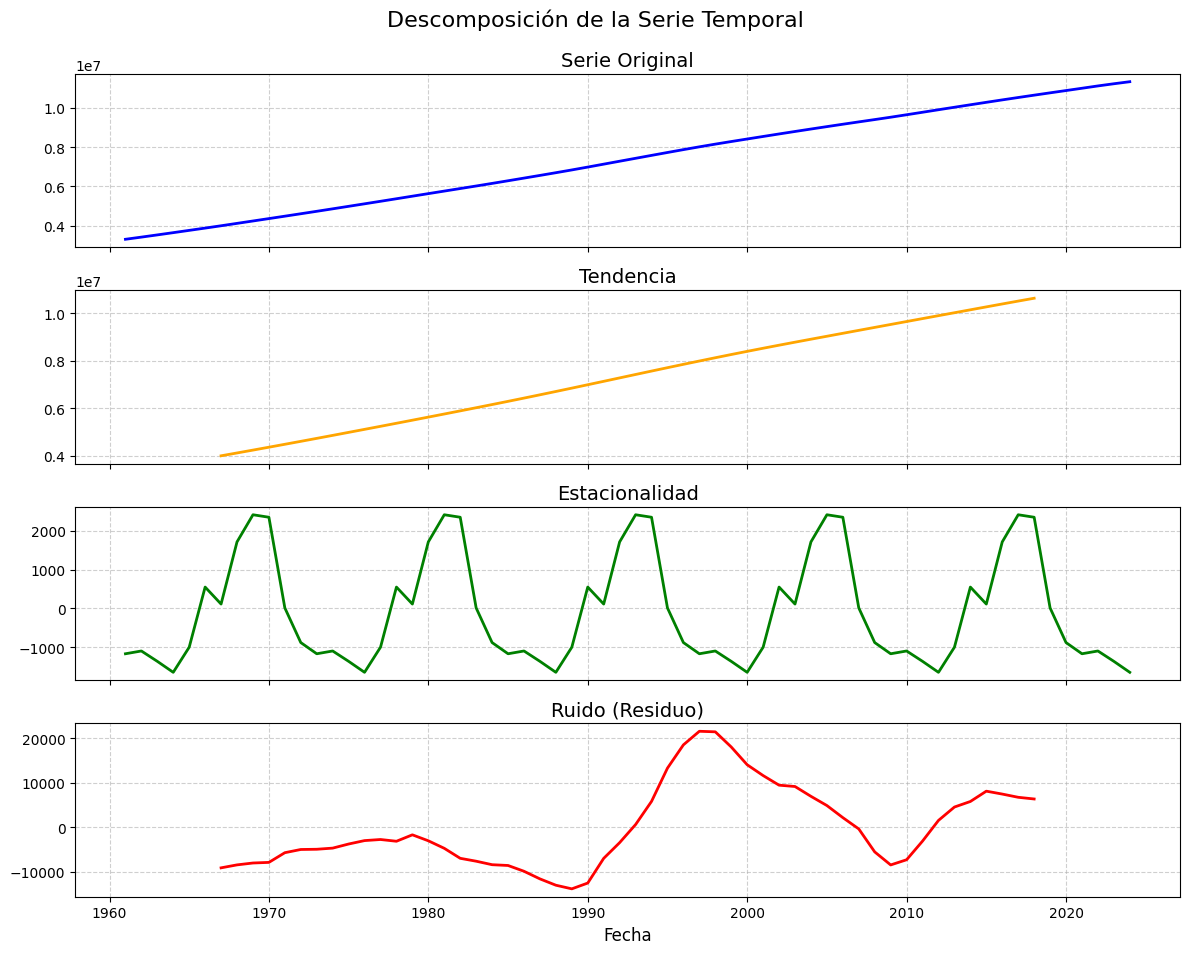

In [418]:
analisis_st.detectar_estacionalidad()

In [419]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -2.019568708932497
p-value: 0.27805935885765015
Valores Críticos:
1%: -3.552928203580539
5%: -2.9147306250000002
10%: -2.595137155612245
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


In [420]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [421]:
train_size= int(0.7 * len(df_poblacion))
df_poblacion.set_index('FECHA', inplace=True)
df_poblacion.index = pd.to_datetime(df_poblacion.index)
# df_autos_historicos = df_autos_historicos.asfreq('A')

y_train, y_test = df_poblacion[:train_size], df_poblacion[train_size:]

In [422]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)
resultados_arima.head(3)

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency A-DEC will be used.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\st

,p,q,RMSE
0,1,1,95902
1,1,2,99603
2,1,3,4155560


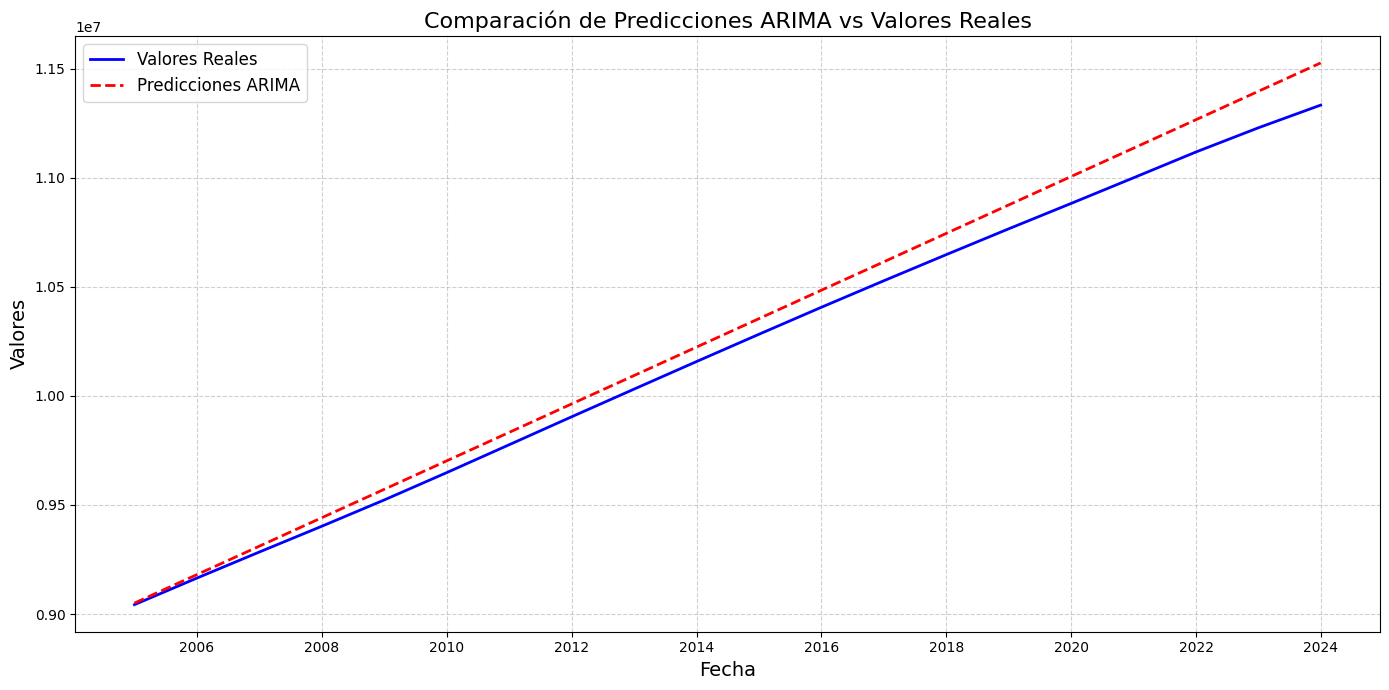

In [423]:
modelo_arima.visualizar_predicciones(y_test)

### Modelo usando Prophet

In [424]:
df_poblacion.reset_index(inplace=True)
df_poblacion.columns = ['ds', 'y']

ARIMA

In [425]:
df_poblacion.head()

,ds,y
0,1960-12-31,3298021
1,1961-12-31,3408415
2,1962-12-31,3521164
3,1963-12-31,3635798
4,1964-12-31,3752313


In [426]:
df_poblacion.tail()

,ds,y
59,2019-12-31,10881882
60,2020-12-31,10999664
61,2021-12-31,11117873
62,2022-12-31,11228821
63,2023-12-31,11332972


In [427]:
m = Prophet()
m.fit(df_poblacion)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=2, freq='Y') 
m.predict(future)

15:52:25 - cmdstanpy - INFO - Chain [1] start processing
15:52:25 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-12-31,207291,3289771,3303097,207291,207291,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,3296446
1,1961-12-31,321164,3402569,3415919,321164,321164,3087991,3087991,3087991,3087991,3087991,3087991,0,0,0,3409155
2,1962-12-31,435036,3515171,3528645,435036,435036,3086860,3086860,3086860,3086860,3086860,3086860,0,0,0,3521896
3,1963-12-31,548939,3628808,3641913,548939,548939,3086464,3086464,3086464,3086464,3086464,3086464,0,0,0,3635403
4,1964-12-31,663154,3745335,3758869,663154,663154,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,3752309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2021-12-31,8029613,11110855,11123936,8029613,8029613,3087991,3087991,3087991,3087991,3087991,3087991,0,0,0,11117604
62,2022-12-31,8150000,11229928,11243504,8150000,8150000,3086860,3086860,3086860,3086860,3086860,3086860,0,0,0,11236860
63,2023-12-31,8270387,11350100,11363577,8270387,8270387,3086464,3086464,3086464,3086464,3086464,3086464,0,0,0,11356851
64,2024-12-31,8391104,11473430,11487065,8389841,8392480,3089154,3089154,3089154,3089154,3089154,3089154,0,0,0,11480258


In [428]:
help(m.make_future_dataframe)

Help on method make_future_dataframe in module prophet.forecaster:

make_future_dataframe(periods, freq='D', include_history=True) method of prophet.forecaster.Prophet instance
    Simulate the trend using the extrapolated generative model.
    
    Parameters
    ----------
    periods: Int number of periods to forecast forward.
    freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
    include_history: Boolean to include the historical dates in the data
        frame for predictions.
    
    Returns
    -------
    pd.Dataframe that extends forward from the end of self.history for the
    requested number of periods.



In [429]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
61,2021-12-31,11117604,11111232,11123918
62,2022-12-31,11236860,11229745,11244107
63,2023-12-31,11356851,11350556,11363395
64,2024-12-31,11480258,11473201,11487177
65,2025-12-31,11599481,11591369,11608249


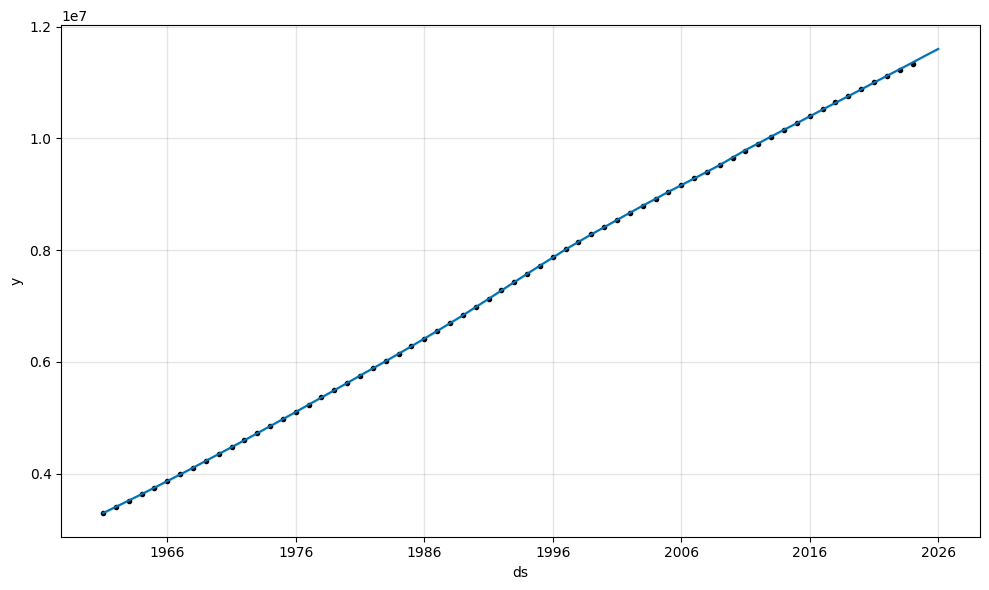

In [430]:
fig1 = m.plot(forecast)

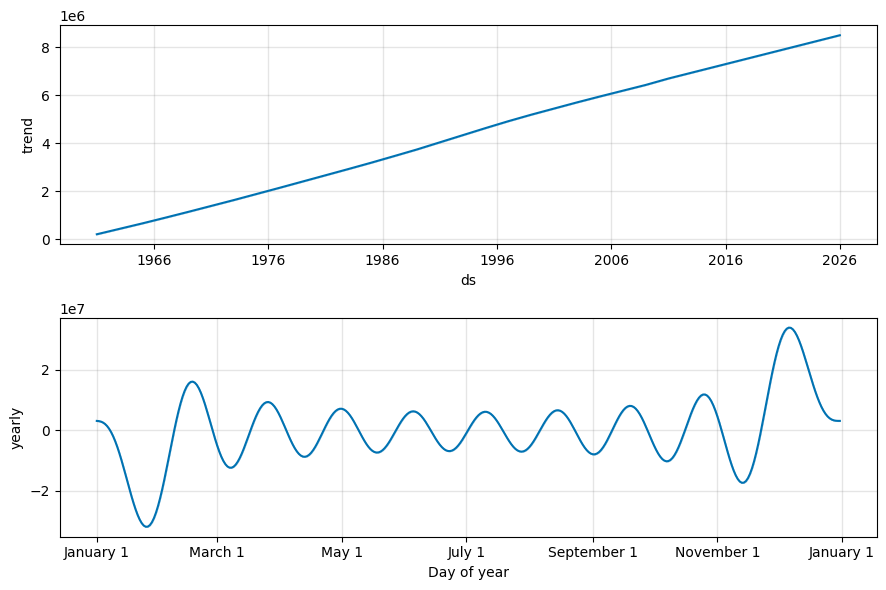

In [431]:
fig2 = m.plot_components(forecast)

In [432]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [433]:
plot_components_plotly(m, forecast)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\io\_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.

